## Análisis de los datos

### Carga de librerías y del conjunto de datos

Importamos las librerías necesarias:

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats as st
from scipy.stats import levene, shapiro, ttest_ind, ttest_1samp
from statsmodels.graphics.gofplots import qqplot

Cargamos los datos limpiados:

In [2]:
dataset = pd.read_csv("../data/madrid-rent-prices_cleaned.csv")
dataset.head()

,Unnamed: 0,_id,zipCode,buildingType,buildingSubtype,clientId,clientTypeId,dateOriginal,bathrooms,balcony,...,isPackPremiumPriority,isNewConstruction,hasOpenHouse,isOpportunity,minPrice,otherFeaturesCount,price,periodicityId,history,lastAccess
0,0,1,28023.0,Flat,GroundFloorWithGarden,id-1,3.0,2022-02-24,2.0,0.0,...,True,False,False,False,0.0,15.0,1325.0,3.0,"[{'date': '2022-04-04', 'price': 1325}]",2022-04-11 07:48:19.078000
1,1,2,28023.0,Flat,Flat,id-1,3.0,2022-02-23,2.0,0.0,...,True,False,False,False,0.0,15.0,1120.0,3.0,"[{'date': '2022-04-04', 'price': 1120}]",2022-04-11 07:48:19.139000
2,2,3,28052.0,Flat,GroundFloorWithGarden,id-2,3.0,2022-03-10,2.0,0.0,...,True,False,False,False,0.0,18.0,1095.0,3.0,"[{'date': '2022-04-04', 'price': 1095}]",2022-04-11 07:49:27.115000
3,3,4,28050.0,Flat,Flat,id-2,3.0,2022-03-01,2.0,0.0,...,True,False,False,False,0.0,17.0,1045.0,3.0,"[{'date': '2022-04-04', 'price': 1045}]",2022-04-11 07:48:19.195000
4,4,5,28001.0,Flat,Flat,id-3,3.0,2022-02-24,3.0,1.0,...,True,False,False,False,0.0,19.0,6550.0,3.0,"[{'date': '2022-04-04', 'price': 6550}]",2022-04-11 07:48:19.251000


### Análisis

Lo primero que hacemos es definir una función que usaremos, y cuyo fin será mostrar las representaciones visuales para comprobar si los datos siguen una distribución normal:

In [3]:
def visualizeNorm(title_fig, data):
    plt.figure(figsize=(12,6))
    plt.title(title_fig)
    
    ax1 = plt.subplot(1,2,1)
    count, bins, ignored = plt.hist(data)
    ax1.set_title('Histogram')
    ax1.set_xlabel('Value bin')
    ax1.set_ylabel('Frequency')

    ax2 = plt.subplot(1,2,2)
    qqplot(data, line='s', ax=ax2)
    ax2.set_title('QQ Plot')

    plt.show()

También realizamos una función que nos aplique el test de Levene sobre dos conjuntos de datos y compruebe si estos tienen iguales varianzas o no:

In [4]:
def showLeveneResult(data1, data2):
    stat, p_value = levene(data1, data2)
    print('Statistics=%.3f, p=%.3f' % (stat, p_value))
    
    alpha = 0.05
    if p_value > alpha:
        print('Equal variances')
    else:
        print('Unequal variances')
        
    print()

Y finalmente, otra que nos muestre si aplicando el test de Shapiro-Wilk, la cual evalúa una muestra si los datos siguen una distribución gaussiana:

In [5]:
def showShapiroWilkResult(data):
    stat, p_value = shapiro(data)
    print('Statistics=%.3f, p=%.3f' % (stat, p_value))
    
    alpha = 0.05
    if p_value > alpha:
        print('Gaussian Distributin')
    else:
        print('Non Gaussian Distribution')
        
    print()

#### Particulares vs Inmobiliarias

El primero de los análisis a llevar a cabo trata de ver si es más barato los inmuebles publicitados por particulares individualmente o por inmobiliaria. Dividimos los conjuntos y comprobamos su normalidad:

In [6]:
pd.unique(dataset.clientTypeId)

array([3., 1.])

In [7]:
datasetParti = dataset[dataset.clientTypeId == 1]
datasetInmob = dataset[dataset.clientTypeId == 3]

Mostrando las representaciones visuales de ambos conjuntos de precios:

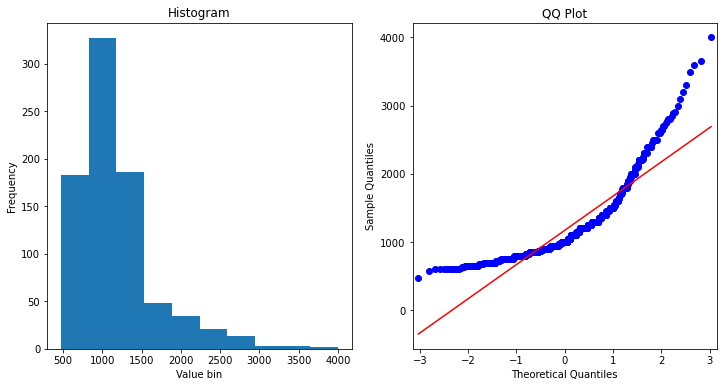

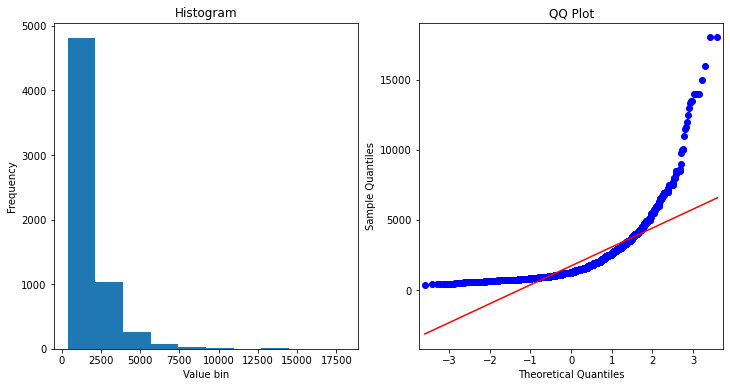

In [8]:
visualizeNorm('Part', datasetParti.price)
visualizeNorm('Inmo', datasetInmob.price)

Como se puede apreciar no sé puede visualmente definir su distribución como normal. Si aplicamos el test de Shapiro-Wilk:

In [9]:
showShapiroWilkResult(datasetParti.price)
showShapiroWilkResult(datasetInmob.price)

Statistics=0.813, p=0.000
Non Gaussian Distribution

Statistics=0.678, p=0.000
Non Gaussian Distribution



/Users/kevin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Vemos que nos refleja que ninguna de las dos sigue una distribución gaussiana. Observando el número de elementos existentes:

In [10]:
print(len(datasetParti.price))
print(len(datasetInmob.price))

822
6234


A pesar de los resultados, como el conjunto de datos se compone de un número de registros suficientemente grande se puede aplicar el _teorema central del límite_ considerando que los datos siguen una distribución normal.

Para comprobar si existe alguna diferencia entre los precios de los anuncios de particulares y las de inmobiliaria, planteamos el siguiente contraste de hipótesis de dos muestras:


H0 : _μ1_ = _μ2_

H1 : _μ1_ < _μ2_


Donde _μ1_ es la media del precio de los inmuebles publicitados por particulares y μ2 es la media de los inmuebles publicitados por inmobiliaria. Pero antes de proseguir comprobamos si las varianzas desconocidas de la población son iguales o no:

In [11]:
showLeveneResult(datasetParti.price, datasetInmob.price)

Statistics=118.579, p=0.000
Unequal variances



En este caso vemos que se rechaza la hipótesis nula ya que es inferior a 0.05, por lo que los grupos tienen varianzas desiguales. Ahora aplicamos el test de Welch’s t-test al establecer el paramétro _equal_var_ a _False_ y comprobar si existe alguna diferencia entre los precios.

In [12]:
ttest_ind(a=datasetParti.price, b=datasetInmob.price, equal_var=False)

Ttest_indResult(statistic=-22.480117818587928, pvalue=5.066671369179183e-103)

Vemos como no se puede  rechazar la hipótesis nula, ya que el p-value es mayor que el nivel de significancia 0.05, con lo que se concluye que no hay una diferencia significativa entre los inmuebles según quién lo publicita.

#### Anuncios PackPremiumPriority, sí o no

El segundo de los análisis es ver si existe una diferencia de precios en los anuncios que utilizan el _PackPremiumPriority_ con los que no. Igual que antes, el primer paso es dividir los conjuntos:

In [13]:
pd.unique(dataset.isPackPremiumPriority)

array([ True, False])

In [14]:
datasetPack = dataset[dataset.isPackPremiumPriority == True]
datasetNoPack = dataset[dataset.isPackPremiumPriority == False]

Mostramos las representaciones visuales de ambos conjuntos de precios:

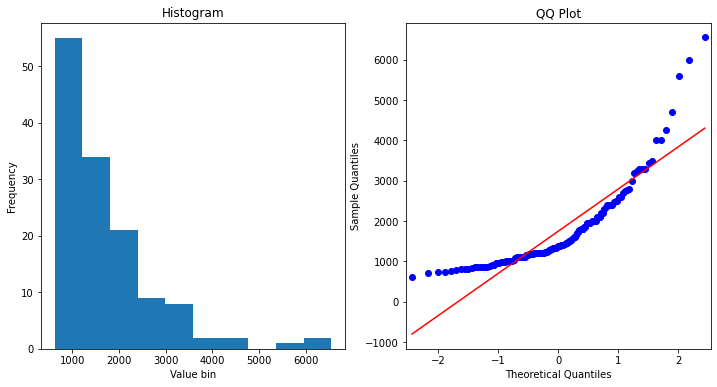

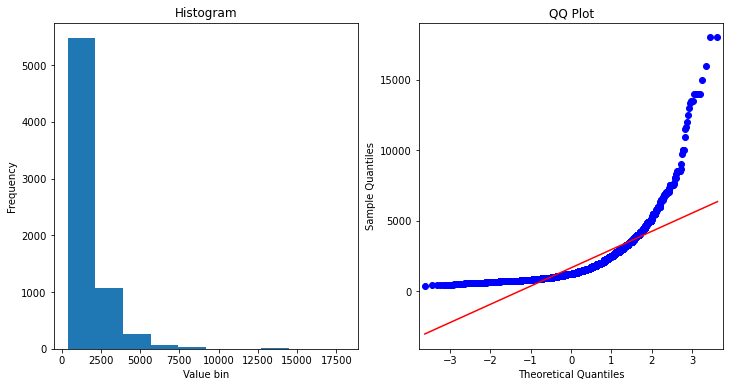

In [15]:
visualizeNorm('Pack', datasetPack.price)
visualizeNorm('No Pack', datasetNoPack.price)

Vemos que tenemos un comportamiento similar al caso anterior y visualmente no se ve que sigan una distribución normal. A nivel del test Shapiro-Wilk:

In [16]:
showShapiroWilkResult(datasetPack.price)
showShapiroWilkResult(datasetNoPack.price)

Statistics=0.789, p=0.000
Non Gaussian Distribution

Statistics=0.664, p=0.000
Non Gaussian Distribution



/Users/kevin/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Vemos que ocurre como en el caso anterior y corrobora lo que se ve en la visualización, no siguen una distribución gaussiana. Observando el número de registros de cada conjunto:





In [17]:
print(len(datasetPack.price))
print(len(datasetNoPack.price))

134
6922


En este caso también podemos aplicar el _teorema central del límite_ considerando que los datos siguen una distribución normal ya que los conjuntos se componen de un número de registros suficientemente grande (N > 30).

Para comprobar si existe alguna diferencia entre las viviendas con publicitadas con pack premium y las que no, planteamos el siguiente contraste de hipótesis de dos muestras:


H0 : _μ1_ = _μ2_

H1 : _μ1_ < _μ2_


Donde _μ1_ es la media del precio de los inmuebles publicitados con pack premium y μ2 es la media de los inmuebles publicitados sin este pack.

In [18]:
showLeveneResult(datasetPack.price, datasetNoPack.price)

Statistics=0.232, p=0.630
Equal variances



En este caso vemos que se acepta la hipótesis nula ya que es superior a 0.05, por lo que los grupos tienen varianzas iguales. Ahora aplicamos el test Student estableciendo el parámetro _equal_var_ a _True_ y comprobar si existe alguna diferencia entre estos precios.

In [19]:
ttest_ind(a=datasetPack.price, b=datasetNoPack.price, equal_var=True)

Ttest_indResult(statistic=0.8335528490808914, pvalue=0.40456122845518816)

Tenemos un p-value mayor que el nivel de significancia 0.05 no se puede rechazar la hipótesis nula, con lo que se concluye que no hay una diferencia significativa entre los inmuebles según los paquetes.

#### Esperar bajadas de precio

Por último vamos a estudiar si existe una bajada de precios considerable en los 5 días que se recolectaron datos. Para ello creamos los conjuntos de datos según los valores existentes en la variable _history_, quedándonos con nuestro primer y último valor (solamente de los inmuebles que cambiaron su precio en esos días):

In [20]:
evolution_list = json.loads(dataset.history.to_json())

price_ini = []
price_end = []

for element in evolution_list:
    evolution_rent = evolution_list[element].replace('[', '').replace(']', '').replace('\'', '"').replace('}, {', '},  {').split(',  ')
    
    if len(evolution_rent) > 2:
        
        price_ini.append(json.loads(evolution_rent[0])['price'])
        price_end.append(json.loads(evolution_rent[-1])['price'])
    
    '''
    evolution = []
    for price in evolution_rent:
        evolution.append(json.loads(price))
        
    evolution_list[element] = evolution
    '''
    
price_ini = np.array(price_ini)
price_end = np.array(price_end)

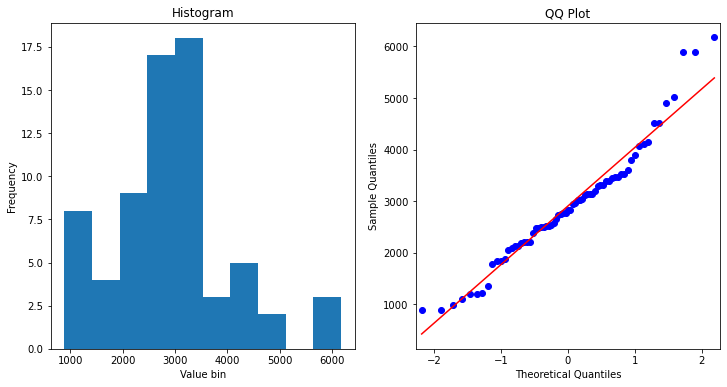

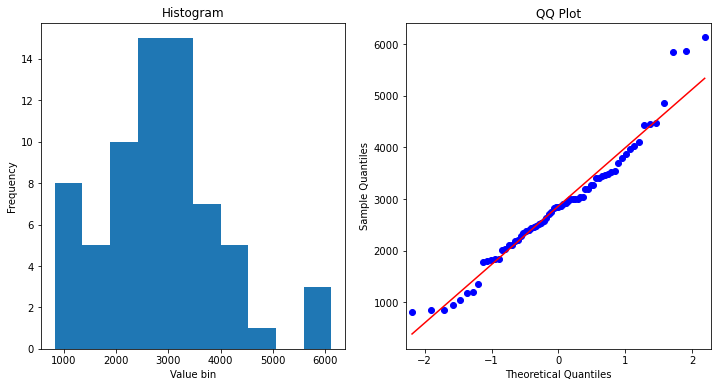

In [21]:
visualizeNorm('Inicial', price_ini)
visualizeNorm('Final', price_end)

En este caso, vemos que este subconjunto de inmuebles visualmente siguen una distribución más cercana a la normal. Aplicando el test Shapiro-Wilk:

In [22]:
showShapiroWilkResult(price_ini)
showShapiroWilkResult(price_end)

Statistics=0.957, p=0.018
Non Gaussian Distribution

Statistics=0.961, p=0.031
Non Gaussian Distribution



Comprobamos que a pesar de que visualmente se vean más cercanos a la distribución normal no llegan a estarlo según el test aplicado.

In [23]:
print(len(price_ini))
print(len(price_end))

69
69


Si aplicamos el _teorema central del límite_ el conjunto de datos es suficientemente grande (N > 30) para considerar que siguen una distribución normal.

Para comprobar si existe alguna diferencia entre el antes y el después planteamos el siguiente contraste unilateral de hipótesis de dos muestras sobre la diferencia de medias:


H0 : _μ1_ − _μ2_ = 0

H1 : _μ1_ − _μ2_ < 0


Donde _μ1_ es la media del precio inicial y μ2 es la media del precio final.

In [24]:
ttest_1samp(a=price_ini - price_end, popmean=0, alternative='less')

Ttest_1sampResult(statistic=2.834859142111296, pvalue=0.9969841398500198)

Debido a que el p-value es mayor que el nivel de significancia de 0.05 fijado no podemos rechazar la hipótesis nula, por lo que podemos concluir que la diferencia del precio de los alquileres no es diferente.

### Conclusiones finales

A partir de aquí podemos concluir que si eres un usuario que busca un contrato de alquiler y queremos ahorrar no tenemos que preocuparnos por si el anuncio es de inmobiliaria o de un particular, ya que los precios no son significativamente diferentes. De igual forma pasa con los anuncios con pack premium y con los que no, a pesar de que la persona propietaria haya asumido este tipo de anuncio no influye en el precio del alquiler.

Por último, vemos que en la evolución de los precios no hay diferencias en intervalos cortos de días, por lo que en el caso de encontrar un inmueble del cual se esté interesado es mejor proceder directamente a su alquiler sin esperar cambios en el precio.